# To-do list

## Metalicty

# To look into list
Hierarchical model <br>
Varitational inference <br>
Different samplers - HMC <br>
Posterior predictive checks 
Use Gyrs 



# rotaation bv and age observers GC
# period age mass and metalictty fundemental GC


In [ ]:
!pip install arviz==0.11.0
!pip install pymc3==3.11.1
!pip install PyAstronomy


In [2]:
import matplotlib.pyplot as plt
import numpy as np
#import scipy
import pandas as pd

import pymc3 as pm
import theano as tt
import arviz 
pd.options.display.max_rows = 4000
 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

print(f"Running on PyMC3 v{pm.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on PyMC3 v3.11.1


In [3]:
def mean_fn(t, B, A, c, h, f):
  return A * (t)**c  * (B-h)**f


def log_mean_fn(log_Age, BV, A,c,h,f):
  return np.log(A) +c*log_Age + f*np.log(BV-h)








def log_err(vals, val, err_lo):
  return np.mean(np.log(vals)) - np.log(np.mean(vals)- err_lo) ## this works 



#def log_err(vals, val, err_lo):
 # return np.log(val) - np.log(val- err_lo)


#def lin_err(vals, val, err_lo):
#  return val * log_err(vals, val, err_lo)

def lin_err(val, sig_hi, sig_lo):
  return (sig_hi +sig_lo)/2
  

In [ ]:
##### OPTIONS #####
#data1 16th points = 91 total






data = pd.read_csv('/content/drive/My Drive/data/real_data.csv', header=0)
flag = np.array(data['flag'])

Teff = np.array(data['Teff'])

Teff_err = np.array(data['eTeff'])

Age = np.array(data['age']) # convert to Megayrs
Age_err_lo = np.array(data['loage'])
Age_err_hi = np.array(data['upage'])

Prot = np.array(data['P'])
Prot_err_lo = np.array(data['l_P'])
Prot_err_hi = np.array(data['u_P'])

b = pyasl.BallesterosBV_T()
data_points = Prot.shape[0]


#Prot_err = np.array([lin_err(Prot, Prot[i], Prot_err_lo[i]) for i in range(data_points)])
#Age_err = np.array([lin_err(Age, Age[i], Age_err_lo[i]) for i in range(data_points)])

Age_err = np.array([lin_err(Age[i], Age_err_lo[i], Age_err_hi[i]) for i in range(data_points)])
Prot_err = np.array([lin_err(Prot[i], Prot_err_lo[i], Prot_err_hi[i]) for i in range(data_points)])


sel_good = np.where((Age > 0.5)& (Prot_err < 40)) # select stars that arent too young and have 'sensible' error

sel_bad = np.where((Prot < 5)& (Prot_err < 40)&(Age>5)) # Remove old stars that spin too fast

sel = (np.delete(sel_good, sel_bad))



Teff = Teff[sel]
Teff_err = Teff_err[sel]
Age = Age[sel]
Age_err_lo = Age_err_lo[sel]
Age_err_hi = Age_err_hi[sel]
Age_err = Age_err [sel]

Prot = Prot[sel]
Prot_err_lo = Prot_err_lo[sel]
Prot_err_hi = Prot_err_hi[sel]
Prot_err = Prot_err [sel]

BV =  b.t2bv(np.array(Teff))

BV_err = Teff_err/Teff * BV

data_points = Prot.shape[0]

print('Using: ',data_points)
print('From: ',data.shape)


In [ ]:




plt.errorbar(Prot, Age,yerr=Age_err,xerr=Prot_err,fmt='o')
plt.show()
plt.plot(Age, np.abs(Age_err), 'ok')

print(np.sort(Prot_err))

In [ ]:
X = np.array([Age, BV]).T 
h = 0.4 
f = 0.601 
c = 0.52
A = 0.7725 * np.sqrt(1000)


b = pyasl.BallesterosBV_T()



Prot_guess  = mean_fn(X[:,0], X[:,1], A, c,h,f)
plt.scatter(X[:,0], Prot_guess,s=300, c=X[:,1], cmap = cm.viridis, label='model')
#plt.show()
plt.scatter(Age, Prot, c=BV,s=100,cmap = cm.viridis, label='data')

plt.show()


data2 = np.genfromtxt('/content/drive/My Drive/data/data1.csv', delimiter=',', skip_header=1)
smp_rt=10
Teff2 = data2[:,0][0::smp_rt] # Teff
Prot2 = data2[:, 1][0::smp_rt]  # Prot
Age2 = data2[:, 2][0::smp_rt]  # Age 
BV2 = b.t2bv(np.array(Teff2))

Prot_guess2 = mean_fn(Age2, BV2, A,c,h,f)

plt.scatter(Age2, Prot_guess2,s=300, c=BV2, cmap = cm.viridis, label='model')
plt.scatter(Age2, Prot2, c=BV2,s=100,cmap = cm.viridis, label='data')
plt.show()


https://iopscience.iop.org/article/10.1088/0004-637X/695/1/679/pdf
In this article a form is given to determine P from Bv and age that is of a slightly sifferent form to what I am currently using.
$P(t, B-V) = t^{0.52} g(B-V -h)^f$ <br>
where $g=0.77, h=0.4, f = 0.6$. I will now construct another GP using this as the mean function and see how it goes.

Im gonna sort of bash the BV dependance onto the end of my current mass, age mean function and see how it goes B). The new mean function will look like $P(t,m,(B-V)) = At^cm^d((B-V)-h)^f$. Where I a taking d from the previous GP, here A is going to be allowed to vary and the starting value will be $A^{\star}g$, where $A^{\star}$ is the A from before.  

This has resulted in considerably better results.


In [ ]:
#### book ####


h = 0.4 
f = 0.601 *1.1
c = 0.5189 
A = 0.7725 * np.sqrt(1000) * 1.1



X = np.array([Age, BV]).T 
print(X.shape)


with pm.Model() as model:
    c_ = pm.Normal('c_', c, 0.054)
    f_ = pm.Normal('f_', f, 0.25)
    A_ = pm.Normal('A_', A, A*0.15)

    
    Age_true = pm.Uniform('Age_true', 0, 14, shape=data_points)
    Age_obs = pm.Normal("Age_obs", Age_true, np.abs(Age_err), observed=X[:,0])


    

    BV_true = pm.Lognormal("BV_true", 1, 1, shape=data_points)
    BV_obs = pm.Normal("BV_obs", BV_true, np.abs(BV_err), observed=X[:,1])


  #  mean = A_* Age_true**c_ * (BV_true - h)**f_
    mean = mean_fn(Age_true, BV_true, A,c,h,f)
    resid = Prot - mean
   
    l1 = pm.Normal('l1', mu=20, sigma=5)  # 20
    #l2 = pm.Normal('l2', mu=0.05, sigma=0.05)
    l2 = pm.Lognormal("l2", np.log(0.05), 0.1)

   # sf1 = pm.Lognormal("sf1", np.log(12), 0.1)
    sf1 = pm.Normal('sf1', 5, 2)
    sf2 = pm.Lognormal("sf2", np.log(2), 1)
    #sf2 = pm.Normal('sf2', 2, 2)

    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2

    K = K1 * K2 # try multiply 


    gp = pm.gp.Marginal(cov_func=K)
    #x = tt.tensor.stack([Age_true, BV_true])

    obs = gp.marginal_likelihood("obs", X=X , y=resid, noise=np.abs(Prot_err))

    # big gp book says constnat plus a product of linear + white noise will do the trick




WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sf2, sf1, l2, l1, BV_true, Age_true, A_, f_, c_]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7474 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


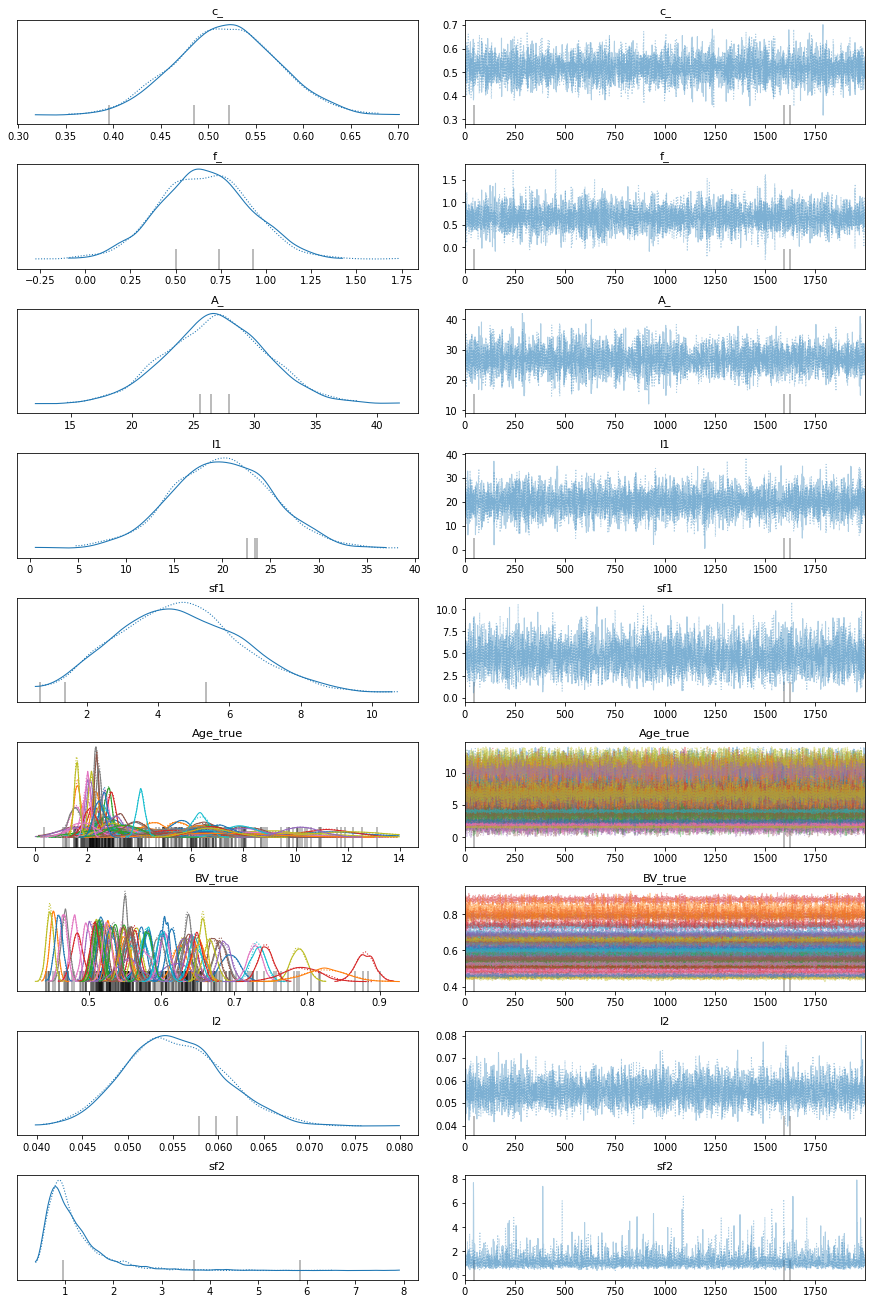

In [8]:

with model:
  trace = pm.sample(2000, tune=2000, cores=2, target_accept=0.995)
  arviz.plot_trace(trace)

In [9]:
with model:
  print(arviz.summary(trace))


lst = trace.varnames
# list of all variables to sample posterior over
lst.append('f_pred')
vars = np.asarray(lst)

with model:
  f_pred = gp.conditional('f_pred', X, pred_noise=False) # predict function
  pred_samples = pm.sample_posterior_predictive(trace, var_names=vars,samples=2500)


                mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
c_             0.519  0.053   0.423  ...    9516.0    2624.0   1.00
f_             0.664  0.253   0.186  ...    9227.0    1994.0   1.00
A_            26.904  4.057  19.925  ...   11553.0    2296.0   1.00
l1            19.939  5.160  10.721  ...    9469.0    2491.0   1.00
sf1            4.634  1.721   1.658  ...    5465.0    3285.0   1.00
Age_true[0]    2.955  0.412   2.202  ...    9214.0    2449.0   1.00
Age_true[1]    1.626  0.141   1.373  ...    7983.0    2848.0   1.00
Age_true[2]    3.269  0.734   1.900  ...    7610.0    2501.0   1.00
Age_true[3]    2.255  0.241   1.797  ...    9986.0    2406.0   1.00
Age_true[4]    2.106  0.125   1.867  ...    9074.0    2552.0   1.00
Age_true[5]    6.599  0.578   5.541  ...    9813.0    2781.0   1.00
Age_true[6]    2.671  0.167   2.364  ...    7663.0    2960.0   1.00
Age_true[7]    8.901  1.515   6.189  ...    7656.0    2370.0   1.00
Age_true[8]    3.122  0.669   1.963  ...    8829

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [ ]:

new_err = np.mean([ trace.get_values('Age_true')[:,i].std()/  trace.get_values('Age_true')[:,i].mean() for i in range(data_points)])
old_err =np.mean(np.abs(Age_err/Age))


print('Initianl error: ', old_err*100, '%')
print('New error: ', new_err*100,'%')
print("I have added {}% error :)".format(round(new_err-old_err,5)*100))


In [11]:
print(trace.get_values('Age_true').shape)
Age_new = np.mean(trace.get_values('Age_true'), axis=0)
BV_new = np.mean(trace.get_values('BV_true'), axis=0)
print(Age_new.shape)

(4000, 91)
(91,)


No handles with labels found to put in legend.


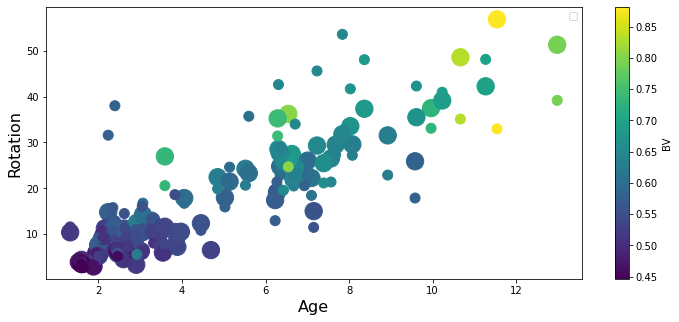

In [12]:

#X = np.array([Age_new, BV_new]).T 
X = np.array([Age, BV]).T 
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()



fit, var = gp.predict(X, point=trace[-1], diag=True)
sd = np.sqrt(var)

mean = mean_fn(X[:,0], X[:,1], A, c ,h,f)

mu = fit + mean

#k = np.argsort(X[:,0])
#plt.fill_between(X[:,0][k], mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)


## plotting the predictions, make a plot of age on x axis b-v on y, plot points and colour by age

plt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 'o', cmap = cm.viridis)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Rotation', fontsize=16)
plt.colorbar(label='BV')
plt.scatter(Age, Prot, c=BV, s=100, cmap = cm.viridis)
plt.legend()
plt.show()

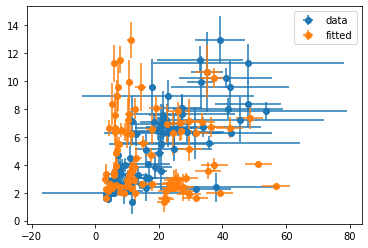

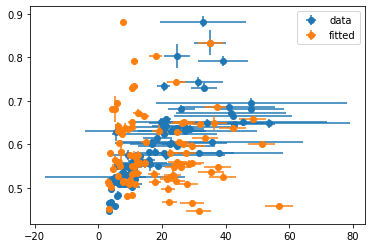

In [13]:
#A = np.mean(trace['A_'])
#c = np.mean(trace['c_'])
#h = h
#f = np.mean(trace['f_'])




fit, var = gp.predict(X, point=trace[-1], diag=True)



mu = mean + fit
std = np.sqrt(var) * np.sign(var)


vals = np.sort(np.array([mu, std, Prot]), axis=1)





age_fit_err = [trace.get_values('Age_true')[:,i].std() for i in range(trace.get_values('Age_true').shape[1])]
bv_fit_err = [trace.get_values('BV_true')[:,i].std() for i in range(trace.get_values('BV_true').shape[1])]


plt.errorbar(Prot, Age, yerr=Age_err, xerr=Prot_err, fmt='o', label='data')
plt.errorbar(vals[0,:], X[:,0], xerr=vals[1,:], yerr=age_fit_err, fmt='o', label='fitted')
plt.legend()
plt.show()


plt.errorbar(Prot, BV, yerr=BV_err, xerr=Prot_err, fmt='o', label='data')



order = np.argsort(X[:,1])


plt.errorbar(vals[0,:][order], X[:,1][order], xerr=vals[1,:][order], yerr=bv_fit_err, fmt='o', label='fitted')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

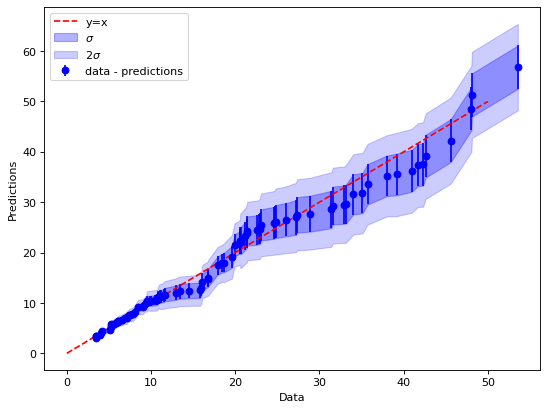

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

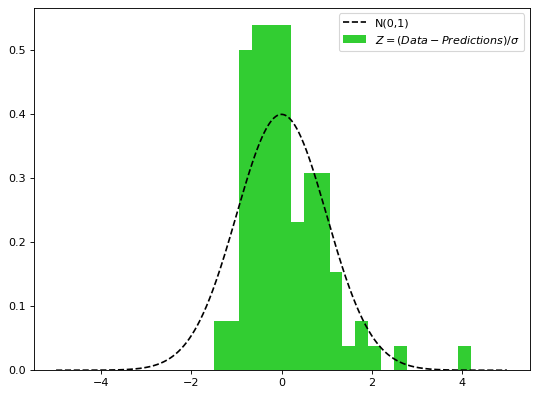

0.0824592429413945


In [16]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot([0, 50], [0, 50], linestyle='--', label='y=x', color='r')
plt.errorbar(vals[2,:], vals[0,:], yerr=vals[1,:], fmt='o', label=r'data - predictions', color='b', alpha=1)
plt.fill_between(vals[2,:], vals[0,:] - vals[1,:], vals[0,:] + vals[1,:], alpha=0.3, label=r'$\sigma$',interpolate=True, color='blue')
plt.fill_between(vals[2,:], vals[0,:] - 2*vals[1,:], vals[0,:] + 2*vals[1,:], alpha=0.2, label=r'$2\sigma$', interpolate=True, color='b')
plt.xlabel('Data')
plt.ylabel('Predictions')
plt.savefig("R4.png")
files.download("R4.png") 
plt.legend()
plt.xlabel('Data')
plt.ylabel('Predictions')
plt.show()


Z = (vals[2,:] - vals[0, :])/(vals[1,:])
x = np.linspace(-5,5, 1000)
norm = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 


plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(Z, density=True, label=r'$Z=(Data-Predictions)/\sigma$', color='limegreen', bins=20)
plt.plot(x,norm, label='N(0,1)', color='k', linestyle='--')
plt.legend()
plt.savefig("H4.png")
files.download("H4.png") 
plt.show()
print(Z.mean())


In [15]:



print(np.mean(np.abs(Prot - vals[0,:]))) 

13.659329961257102
13.659329961257102


These two plots are evidence that this model does fit the data very well. We can use the parameters and hyper parameters gathered here for future GP implementations on true data. 

Second fast component t the gp when we dont have B-V